In [231]:
import sys
sys.path.append('../')
import pystan
import stan_utility
import pandas as pd
import seaborn as sns

import arviz as az
import numpy as np
import scipy.stats as stats
from scipy.stats import kde

In [232]:
import matplotlib.pyplot as plt
import matplotlib as mpl

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200


## Gamma/inverse Gamma distribution

Gamma family distributions. These distributions are defined for positive real numbers. Provide histograms of Gamma and invGamma distributions. See how tail behavior of those distributions behave. Using albebra_solver (see notebook from lecture on poisson distribution modelling) find parameters for Gamma and invGamma for which 98% probability is for values between 5 and 10. Sample for those distributions and compare histograms.

In [233]:
with open('gamma.stan', 'r') as file:
    print(file.read())

data {
  real alpha;
  real beta;
}


generated quantities {
    real gamma = gamma_rng(alpha,beta);
    real inv_gamma = inv_gamma_rng(alpha,beta);
}


In [234]:
model=stan_utility.compile_model('gamma.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e2bba17566b20313406615f2c24c15a5 NOW.


In [235]:
R=1000
sim_nm=model.sampling(data={'alpha':3, 'beta':2},
                      algorithm="Fixed_param", 
                      iter=R, 
                      warmup=0, 
                      chains=1,
                      seed=29042020)

In [236]:
params=sim_nm.extract()
gamma=params['gamma']
inv_gamma=params['inv_gamma']

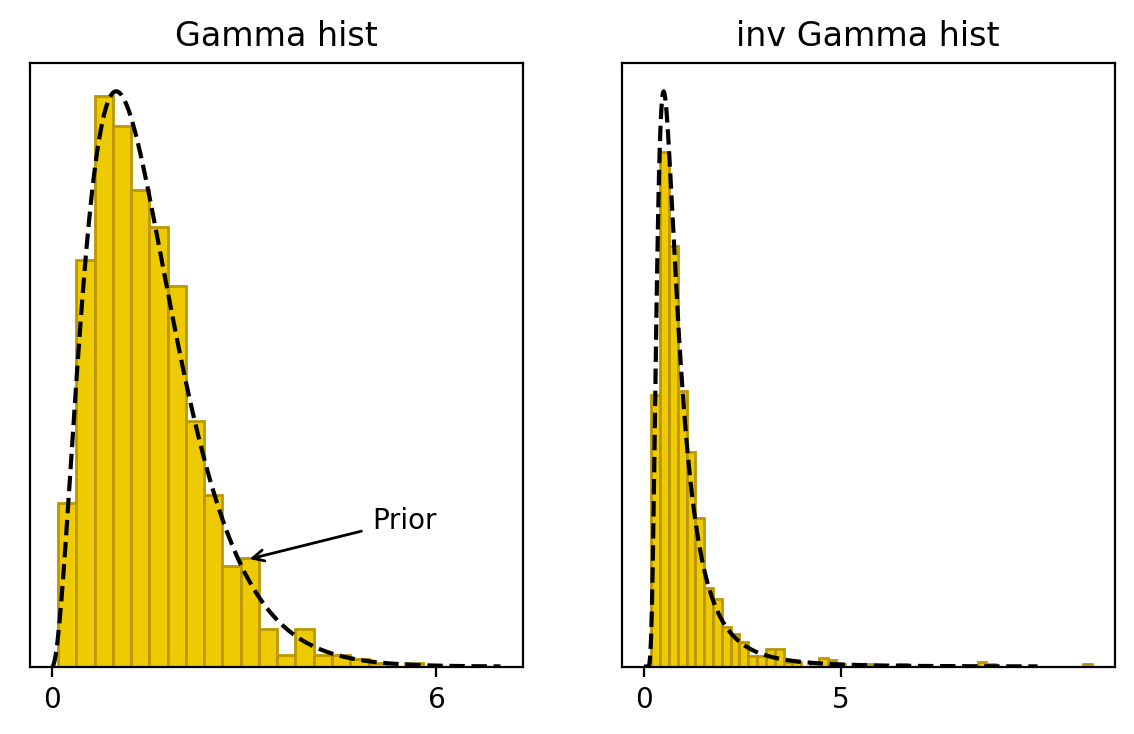

In [237]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))
ax1=axes[0]
ax1.hist(gamma,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,7,500)
alpha = 3
beta = 2
ax1.plot(x,stats.gamma.pdf(x,a=alpha,scale=1/beta),color='black',linestyle='--')
ax1.set_xticks([0,6])
ax1.set_yticks([])
ax1.set_title(r'Gamma hist')
ax1.annotate('Prior',xy=(3,0.1),xytext=(5,0.13),arrowprops={'arrowstyle':'->'})

ax2=axes[1]
ax2.hist(inv_gamma,bins=50,color=dark,edgecolor=dark_highlight,density=True)
x2=np.linspace(0,10,500)
ax2.plot(x2,stats.invgamma.pdf(x2,a=alpha,scale=beta),color='black',linestyle='--')
ax2.set_yticks([])
ax2.set_xticks([0,5])
ax2.set_title('inv Gamma hist')
plt.show()

In [238]:
with open('gamma_5_10.stan', 'r') as file:
    print(file.read())

functions {
  vector gamma_solver(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[3] deltas;
    
    deltas[1] = gamma_cdf(theta[1], y[1], y[2]) - y[3];
    deltas[2] = gamma_cdf(theta[2], y[1], y[2]) - (y[3] + 0.98);
    deltas[3] = y[1]/y[2] -8;
    //deltas[3] = 0.98 - y[4] + y[3];
    
    
    return deltas;
  }
}

data {
  vector[2] theta;     
  vector[3] y_guess;
}

transformed data {
  vector[3] y;
  real x_r[0];
  int x_i[0];
  
  // Find gauss standard deviation that ensures 98% probabilty between 5 and 10
  y = algebra_solver(gamma_solver, y_guess, theta, x_r, x_i);
  
  print("Result: ", y[1]," ", y[2], " ", y[3]);
}

generated quantities {
    real gamma = gamma_rng(y[1],y[2]);
    real inv_gamma = inv_gamma_rng(y[1],y[2]);
}


In [ ]:
model=stan_utility.compile_model('gamma_5_10.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f745f5bf88da620e11f6ea11d198d67c NOW.


In [ ]:
R=1000
sim_nm=model.sampling(data={'y_guess':[6, 0.8, 0.01], 'theta':[5,10]},
                      algorithm="Fixed_param", 
                      iter=R, 
                      warmup=0, 
                      chains=1,
                      seed=29042020)

In [ ]:
params2=sim_nm.extract()
gamma=params2['gamma']
inv_gamma=params2['inv_gamma']

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))
ax1=axes[0]
ax1.hist(gamma,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(3,13,500)
alpha = 75.8152
beta = 9.4769
ax1.plot(x,stats.gamma.pdf(x,a=alpha,scale=1/beta),color='black',linestyle='--')
ax1.set_xticks([3,5,10,13])
#ax1.set_yticks([])
ax1.set_title(r'Gamma hist')
ax1.annotate('Prior',xy=(6.5,0.1),xytext=(3,0.2),arrowprops={'arrowstyle':'->'})

ax2=axes[1]
ax2.hist(inv_gamma,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x2=np.linspace(0,0.3,100)
ax2.plot(x2,stats.invgamma.pdf(x2,a=alpha,scale=beta),color='black',linestyle='--')
#ax2.set_yticks([])
ax2.set_xticks([0,0.3])
ax2.set_title('inv Gamma hist')
plt.show()

In [ ]:
fig, ax2 = plt.subplots(1, 1,figsize=(7, 4))
x2=np.linspace(3,13,1000)
x4=np.linspace(5,10,1000)
ax2.plot(x2,stats.gamma.pdf(x= x2,a= alpha,loc= 0,scale= 1/beta),color=green,linewidth=2)
ax2.fill_between(x4,stats.gamma.pdf(x= x4,a= alpha,loc= 0,scale= 1/beta),0,color=dark)
#ax2.set_yticks([])
ax2.set_xticks([3,5,10,13])
ax2.set_title(r'gamma 98% between 5 and 10')
plt.show()

Inverse gamma where 98% is between 5 and 10.

In [24]:
with open('inv_gamma_5_10.stan', 'r') as file:
    print(file.read())

functions {
  vector gamma_solver(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[3] deltas;
    
    deltas[1] = inv_gamma_cdf(theta[1], y[1], y[2]) - y[3];
    deltas[2] = inv_gamma_cdf(theta[2], y[1], y[2]) - (y[3] + 0.98);
    deltas[3] = y[2]/(y[1]-1) - 10;
    //deltas[3] = 0.98 - y[4] + y[3];
    
    
    return deltas;
  }
}

data {
  vector[2] theta;     
  vector[3] y_guess;
}

transformed data {
  vector[3] y;
  real x_r[0];
  int x_i[0];
  
  // Find gauss standard deviation that ensures 98% probabilty between 5 and 10
  y = algebra_solver(gamma_solver, y_guess, theta, x_r, x_i);
  
  print("Result: ", y[1]," ", y[2], " ", y[3]);
}

generated quantities {
    real gamma = gamma_rng(y[1],y[2]);
    real inv_gamma = inv_gamma_rng(y[1],y[2]);
}


In [25]:
model=stan_utility.compile_model('inv_gamma_5_10.stan')

Using cached StanModel


In [26]:
R=1000
sim_nm=model.sampling(data={'y_guess':[2, 10, 0.0001], 'theta':[5,10]},
                      algorithm="Fixed_param", 
                      iter=R, 
                      warmup=0, 
                      chains=1,
                      seed=29042020)

RuntimeError: Exception: algebra_solver: the norm of the algebraic function is: 0.287452 but should be lower than the function tolerance: 1e-006. Consider decreasing the relative tolerance and increasing the max_num_steps.  (in 'unknown file name' at line 26)


In [ ]:
params2=sim_nm.extract()
gamma=params2['gamma']
inv_gamma=params2['inv_gamma']

In [ ]:
# W przypadku odnalezienia odpowiednich parametrów należy uzupełnić :)
fig, axes = plt.subplots(1, 2, figsize=(7, 4))
ax1=axes[0]
ax1.hist(gamma,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(3,13,500)
alpha = ? 
beta = ?
ax1.plot(x,stats.gamma.pdf(x,a=alpha,scale=1/beta),color='black',linestyle='--')
ax1.set_xticks([3,5,10,13])
#ax1.set_yticks([])
ax1.set_title(r'Gamma hist')
ax1.annotate('Prior',xy=(6.5,0.1),xytext=(3,0.2),arrowprops={'arrowstyle':'->'})

ax2=axes[1]
ax2.hist(inv_gamma,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x2=np.linspace(0,0.3,100)
ax2.plot(x2,stats.invgamma.pdf(x2,a=alpha,scale=beta),color='black',linestyle='--')
#ax2.set_yticks([])
ax2.set_xticks([0,0.3])
ax2.set_title('inv Gamma hist')
plt.show()

### Nie udało się odnaleźć odpowiednich parametrów dla rozkładu Inverse-gamma

# 2. Negative binomial distribution

Negative binomial distribution. Negative binomial distribution can be used in order to relax the constraints of equal mean and variance of Poissson distribution. Using both concentration and dispersion parametrization sample from negative binomial with fixed mean and see how it behaves in comparison to the Poisson with the same mean

In [ ]:
with open('negative_binomial.stan', 'r') as file:
    print(file.read())

In [ ]:
model=stan_utility.compile_model('negative_binomial.stan')

In [ ]:
alpha = 2
mean = 16
beta = alpha/mean

mu = mean
phi = 9

In [ ]:
R=1000
sim_uf=model.sampling(data={'alpha':alpha, 'mean_1':mu,'phi':phi},
                                    algorithm="Fixed_param", 
                                    iter=R, 
                                    warmup=0, 
                                    chains=1, 
                                    refresh=R,
                                    seed=29042020)

In [ ]:
params=sim_uf.extract()
neg_bin_con=params['neg_bin_con']
poisson_con=params['poisson_con']
neg_bin_dis=params['neg_bin_dis']
poisson_dis=params['poisson_dis']

In [ ]:
x_con=np.linspace(0, 80, 81)
x_dis=np.linspace(0, 45, 46)
nbinom_fun_con = stats.nbinom(alpha, beta/(beta+1))
nbinom_fun_dis = stats.nbinom(phi, phi/(mu+phi))

nbinom_pmf_con = []
nbinom_pmf_dis = []

for i in range(0, len(x_con)):
    nbinom_pmf_con.append( nbinom_fun_con.pmf( x_con[i] ))
for i in range(0, len(x_dis)):
    nbinom_pmf_dis.append( nbinom_fun_dis.pmf( x_dis[i] ))
    

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))

ax1=axes[0]
ax1.hist(neg_bin_con,bins=20, color=dark, edgecolor=dark_highlight, density=True)
ax1.plot(x_con, nbinom_pmf_con,  'ro', markersize=4)
ax1.set_xticks([0,16,30,100])
#ax1.set_yticks([])
ax1.set_title(r'Negative binomial concentration')

ax2=axes[1]
ax2.hist(poisson_con,color=dark,edgecolor=dark_highlight,density=True,bins=20)
ax2.set_yticks([])
ax2.set_xticks([0,16,30,100])
ax2.set_title('Poisson')

plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))

ax1=axes[0]
ax1.hist(neg_bin_dis,color=dark,edgecolor=dark_highlight,density=True,bins=20)
ax1.plot(x_dis, nbinom_pmf_dis,  'ro', markersize=4)
ax1.set_xticks([0,16,30])
#ax1.set_yticks([])
ax1.set_title('Negative binomial dispersion')

ax2=axes[1]
ax2.hist(poisson_dis,color=dark,edgecolor=dark_highlight,density=True,bins=20)
ax2.set_yticks([])
ax2.set_xticks([0,16,30])
ax2.set_title('Poisson')

plt.show()

# 3. Student-t family distributions

Student-t distributions can be considered generalizations of Gaussian distributions with varying scale. Use both degrees of freedom and dispersion parametrizations to see how changing parameters moves from normal distribution. Take a special case of degrees of freedom equal to 1, as this is Cauchy distribution. See how mean and variance behave while you increase number of samples.

In [ ]:
with open('student_t.stan', 'r') as file:
    print(file.read())

In [ ]:
model=stan_utility.compile_model('student_t.stan')

In [ ]:
degrees = 1
mu = 0
sigma = 2

In [ ]:
R1=10
sim_nm1=model.sampling(data={'degrees':1, 'mu':0, 'sigma':2},
                      algorithm="Fixed_param", 
                      iter=R1, 
                      warmup=0, 
                      chains=1,
                      seed=29042020)
R2=100
sim_nm2=model.sampling(data={'degrees':1, 'mu':0, 'sigma':2},
                      algorithm="Fixed_param", 
                      iter=R2, 
                      warmup=0, 
                      chains=1,
                      seed=29042020)

In [ ]:
params1=sim_nm1.extract()
student1=params1['student']

params2=sim_nm2.extract()
student2=params2['student']

In [ ]:
x=np.linspace(-20,20,200)

fig, axes = plt.subplots(1, 2, figsize=(7, 4))

fig.suptitle('Student t - degree = 1 (Cauchy)',x= 0.5,y=1, fontsize=12)

ax1=axes[0]
ax1.hist(student1,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax1.plot(x,stats.t.pdf(x,df=1,loc=0,scale=2),color='black',linestyle='--')
# ax1.set_xticks([0,6])
# ax1.set_yticks([])
ax1.annotate('Prior',xy=(3,0.06),xytext=(5,0.13),arrowprops={'arrowstyle':'->'})
ax1.set_title(r'quantity= 10')

ax2=axes[1]
ax2.hist(student2,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.plot(x,stats.t.pdf(x,df=1,loc=0,scale=2),color='black',linestyle='--')
ax2.annotate('Prior',xy=(3,0.06),xytext=(5,0.13),arrowprops={'arrowstyle':'->'})
ax2.set_title(r'quantity= 100')

plt.show()

In [ ]:
np.median(student1)

In [ ]:
np.median(student2)

In [ ]:
az.hpd(student1,0.1)

In [ ]:
az.hpd(student2,0.1)

In [ ]:
degrees = 3
mu = 5
sigma = 4

In [ ]:
R1=10
sim_nm1=model.sampling(data={'degrees':degrees, 'mu':mu, 'sigma':sigma},
                      algorithm="Fixed_param", 
                      iter=R1, 
                      warmup=0, 
                      chains=1,
                      seed=29042020)
R2=100
sim_nm2=model.sampling(data={'degrees':degrees, 'mu':mu, 'sigma':sigma},
                      algorithm="Fixed_param", 
                      iter=R2, 
                      warmup=0, 
                      chains=1,
                      seed=29042020)

In [ ]:
params1=sim_nm1.extract()
student1=params1['student']

params2=sim_nm2.extract()
student2=params2['student']

In [ ]:
x=np.linspace(-20,20,200)

fig, axes = plt.subplots(1, 2, figsize=(7, 4))

fig.suptitle('Student t - degree = 3)',x= 0.5,y=1, fontsize=12)

ax1=axes[0]
ax1.hist(student1,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax1.plot(x,stats.t.pdf(x, df=degrees, loc=mu, scale=sigma),color='black',linestyle='--')
# ax1.set_xticks([0,6])
# ax1.set_yticks([])
ax1.annotate('Prior',xy=(6,0.09),xytext=(10,0.13),arrowprops={'arrowstyle':'->'})
ax1.set_title(r'quantity= 10')

ax2=axes[1]
ax2.hist(student2,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.plot(x,stats.t.pdf(x, df=degrees, loc=mu, scale=sigma),color='black',linestyle='--')
ax2.annotate('Prior',xy=(5,0.09),xytext=(8,0.11),arrowprops={'arrowstyle':'->'})
ax2.set_title(r'quantity= 100')

plt.show()

In [ ]:
np.median(student1)

In [ ]:
np.median(student2)

In [ ]:
az.hpd(student1,0.1)

In [ ]:
az.hpd(student2,0.1)

# 4. Multivariate normal distributions

Multivariate normal distributions Consider density plots and 2d histograms for visualisation of behavior of 2 dimensional Multivariate normal. Use the correlation matrix decomposition of covariance matrix to see how individual variances and correlations infulence the distribution. For 3 and 4 dimensional normal distributions observe the marginals of variables with histograms.

In [ ]:
with open('multivariate.stan', 'r') as file:
    print(file.read())

In [ ]:
model=stan_utility.compile_model('multivariate.stan')

In [ ]:
mu = [2, 8]
sigma = [[1, 0.3], [0.3, 2]]

In [ ]:
def cov2corr(cov, return_std=False):
    '''convert covariance matrix to correlation matrix

    Parameters
    ----------
    cov : array_like, 2d
        covariance matrix, see Notes

    Returns
    -------
    corr : ndarray (subclass)
        correlation matrix
    return_std : bool
        If this is true then the standard deviation is also returned.
        By default only the correlation matrix is returned.

    Notes
    -----
    This function does not convert subclasses of ndarrays. This requires
    that division is defined elementwise. np.ma.array and np.matrix are allowed.

    '''
    cov = np.asanyarray(cov)
    std_ = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std_, std_)
    if return_std:
        return corr, std_
    else:
        return corr

In [ ]:
correlation_matrix= cov2corr(sigma)
correlation_matrix

In [ ]:
R1=100
sim_nm1=model.sampling(data={'mu':mu, 'sigma':sigma},
                      algorithm="Fixed_param", 
                      iter=R1, 
                      warmup=0, 
                      chains=1,
                      seed=29042020)

In [ ]:
params1=sim_nm1.extract()
result=params1['result']
result1= [result[i][0] for i in range(0,100)]
result2= [result[i][1] for i in range(0,100)]

In [ ]:
df = pd.DataFrame(result, columns=["normal1", "normal2"])
sns.jointplot(x="normal1", y="normal2", data=df);

In [ ]:
x=np.linspace(-20,20,200)

fig, axes = plt.subplots(1, 1, figsize=(4, 4))

#fig.suptitle('Student t - degree = 3)',x= 0.5,y=1, fontsize=12)

axes.hist2d(result1,result2,bins=20,color=dark,edgecolor=dark_highlight, density=True)
# # ax1.set_xticks([0,6])
# # ax1.set_yticks([])
axes.set_title(r'hist2d')
plt.xlabel('normal1')
plt.ylabel('normal2')

plt.show()

In [ ]:
# create data
x= np.array(result1)
y = np.array(result2)

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
plt.show()

# 3dim

In [ ]:
with open('multivariate3.stan', 'r') as file:
    print(file.read())

In [ ]:
model=stan_utility.compile_model('multivariate3.stan')

In [ ]:
mu = [2, 8, 12]
sigma = [[1, 0.3, 0.5], [0.3, 2, 0.8],[0.5, 0.8, 12]]

In [ ]:
R1=100
sim_nm1=model.sampling(data={'mu':mu, 'sigma':sigma},
                      algorithm="Fixed_param", 
                      iter=R1, 
                      warmup=0, 
                      chains=1,
                      seed=29042020)

In [ ]:
params1=sim_nm1.extract()
result=params1['result']
result
result1= [result[i][0] for i in range(0,100)]
result2= [result[i][1] for i in range(0,100)]
result3= [result[i][2] for i in range(0,100)]

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(7, 2))

fig.suptitle('marginals',x= 0.5,y=1.1, fontsize=12)

ax1=axes[0]
ax1.hist(result1,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax1.set_title(r'normal1')

ax2=axes[1]
ax2.hist(result2,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title(r'normal2')

ax2=axes[2]
ax2.hist(result3,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title(r'normal3')

plt.show()

In [ ]:
with open('multivariate4.stan', 'r') as file:
    print(file.read())

In [ ]:
model=stan_utility.compile_model('multivariate4.stan')

In [ ]:
mu = [2, 8, 12, 4]
sigma = [[1, 0.3, 0.5, 0.7], [0.3, 2, 0.8, 0.2],[0.5, 0.8, 12, 0.3], [0.7, 0.2, 0.3, 1]]

In [ ]:
R1=100
sim_nm1=model.sampling(data={'mu':mu, 'sigma':sigma},
                      algorithm="Fixed_param", 
                      iter=R1, 
                      warmup=0, 
                      chains=1,
                      seed=29042020)

In [ ]:
params1=sim_nm1.extract()
result=params1['result']
result
result1= [result[i][0] for i in range(0,100)]
result2= [result[i][1] for i in range(0,100)]
result3= [result[i][2] for i in range(0,100)]
result4= [result[i][3] for i in range(0,100)]

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))

fig.suptitle('marginals',x= 0.5,y=0.97, fontsize=12)

ax1=axes[0][0]
ax1.hist(result1,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax1.set_title(r'normal1')

ax2=axes[0][1]
ax2.hist(result2,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title(r'normal2')

ax2=axes[1][0]
ax2.hist(result3,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title(r'normal3')

ax2=axes[1][1]
ax2.hist(result4,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title(r'normal4')

plt.show()